#  RIF Data Wrangling - GDELT

In this notebook, We will go through how to use Google BigQuery to access the GDELT project data, and some simple usage cases.  

Useful References:  
- Google Cloud
    - Google BigQuery: https://cloud.google.com/bigquery
    - Authenticate with Google Cloud: https://hevodata.com/learn/bigquery-jupyter-notebook/#w5
    - Google BigQuery Python Documantation: https://cloud.google.com/python/docs/reference/bigquery/latest/index.html
    - Google BigQuery Python Samples:https://cloud.google.com/bigquery/docs/samples
- GDELT
    - Raw Data: http://data.gdeltproject.org/events/index.html
    - A description of the data fields: http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf
    - The event codes are described in this document: http://gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf
    - CAMEO country codes are listed here: https://www.gdeltproject.org/data/lookups/CAMEO.country.txt
    - FIPS country codes are listed here: https://www.gdeltproject.org/data/lookups/FIPS.country.txt

In [2]:
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
!pip install db-dtypes
!pip install basemap
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: google-cloud-bigquery[bqstorage,pandas] in /home/jovyan/.local/geoai-py3-0.8.0/lib/python3.6/site-packages (3.2.0)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import sys
import math

import numpy as np
import geopandas as gpd

from google.cloud import bigquery

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import networkx as nx

In [4]:
%load_ext google.cloud.bigquery

## **Step 0**: Google BigQuery Account

Authenticate with Google Cloud:  
You need to authenticate your Python code to access Google Cloud resources. You can do this by creating a service account and downloading the JSON key file.  
- Create a service account and download the JSON key file (reference: https://hevodata.com/learn/bigquery-jupyter-notebook/#w5):
    - Go to the Google Cloud Console.
    - Navigate to "IAM & Admin" > "Service accounts."
    - Click "Create Service Account," fill out the details, and grant the necessary permissions (BigQuery User or Editor role).
    - Create and download a JSON key file for the service account.
- Set the GOOGLE_APPLICATION_CREDENTIALS environment variable to point to your JSON key file:  
```python
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "path-to-CREDENTIALS.json"
```

In [5]:
# Setting your Google application credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "iguide-gdelt.json"

- Simple test (good to continue if you see a table output)

In [6]:
# Construct a BigQuery client object.
client = bigquery.Client()
sql = """
SELECT
    plurality,
    COUNT(1) AS count,
    year
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(plurality) AND plurality > 1
GROUP BY
    plurality, year
ORDER BY
    count DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,plurality,count,year
0,2,139209,2007
1,2,138866,2008
2,2,137239,2006
3,2,133285,2005
4,2,132344,2004


## BigQuery GDELT Dataset Overview

The database structure is project --> dataset --> table. The project id for the GDELT project in Google BigQuery is `"gdelt-bq"`.   

### 1. Datasets and tables.  
First, we investigate what datasets and tables are accessible.

In [7]:
# Project id of the GDELT project
project_id = "gdelt-bq"

# Create a BigQuery client object
client = bigquery.Client(project=project_id)

In [8]:
# List all datasets and tables in the GDELT project
datasets = list(client.list_datasets())

# Iterate through each dataset and list its tables
for dataset in datasets:
    print("Dataset: {}".format(dataset.dataset_id))
    tables = list(client.list_tables(dataset))
    table_names = [table.table_id for table in tables]
    print("Tables: {}\n--------".format(", ".join(table_names)))

Dataset: covid19
Tables: onlinenews, onlinenewsgeo, tvnews
--------
Dataset: extra
Tables: countries_by_media_50pct, countrygeolookup, countryinfo, countryinfo2, sourcesbycountry, toytonelookup
--------
Dataset: full
Tables: crosswalk_geocountrycodetohuman, events, events_partitioned
--------
Dataset: gdeltv2
Tables: academicliteraturegkg, cloudvision, cloudvision_partitioned, cloudvision_webentitygraph_20191020, domainsbycountry_alllangs_april2015, eventmentions, eventmentions_partitioned, events, events_partitioned, gal, gdg_partitioned, geg_g1, geg_gcnlapi, geg_gcnlapisent, geg_iatv, gegv2_iatv, gemg, gfg_linguistic1grams_20190831, gfg_linguistic2grams_20190831, gfg_linguisticinventory_20190901, gfg_outlet1grams_20190831, gfg_outlet2grams_20190831, gfg_partitioned, ggg, gkg, gkg_partitioned, gkg_socialoutlinks, gng, gqg, grg_dtn, grg_vcn, grg_vcn_nlpapi, gsg, gsg_docembed, gsg_iatvsentembed, iaradio_1grams, iaradio_2grams, iaradio_3grams, iaradio_4grams, iaradio_5grams, iatv_1grams,

### 2. Tables in the dataset.  
There are two ways to check tables in a certain dataset, you can use either use the BigQuery client library directly or bigquery magic function `%%bigquery`. The magic function `%%bigquery` takes SQL as input and generate the pandas table directly.

a. BigQuery client library

In [9]:
# Check specific dataset
dataset_ref = client.dataset("full")
dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

crosswalk_geocountrycodetohuman
events
events_partitioned


In [10]:
# Do not put project="gdelt-bq" in since this create a new table
client = bigquery.Client()
sql = """
SELECT * FROM `gdelt-bq`.full.INFORMATION_SCHEMA.TABLES;
"""
table_df_1 = client.query(sql).to_dataframe()
table_df_1.head()

,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time,base_table_catalog,base_table_schema,base_table_name,snapshot_time_ms,ddl,default_collation_name,upsert_stream_apply_watermark
0,gdelt-bq,full,events,BASE TABLE,YES,NO,2016-05-19 16:21:47.091000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events`\n(\n GLOB...,NULL,NaT
1,gdelt-bq,full,crosswalk_geocountrycodetohuman,BASE TABLE,YES,NO,2014-07-18 00:35:19.687000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.crosswalk_geocount...,NULL,NaT
2,gdelt-bq,full,events_partitioned,BASE TABLE,YES,NO,2016-05-20 15:56:23.559000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events_partitioned...,NULL,NaT


b. magic function `%%bigquery`

In [11]:
%%bigquery
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.TABLES`

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.37rows/s]


,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time,base_table_catalog,base_table_schema,base_table_name,snapshot_time_ms,ddl,default_collation_name,upsert_stream_apply_watermark
0,gdelt-bq,full,events,BASE TABLE,YES,NO,2016-05-19 16:21:47.091000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events`\n(\n GLOB...,NULL,NaT
1,gdelt-bq,full,crosswalk_geocountrycodetohuman,BASE TABLE,YES,NO,2014-07-18 00:35:19.687000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.crosswalk_geocount...,NULL,NaT
2,gdelt-bq,full,events_partitioned,BASE TABLE,YES,NO,2016-05-20 15:56:23.559000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events_partitioned...,NULL,NaT


In [12]:
%%bigquery table_df_2
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.TABLES`

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.61rows/s]


In [13]:
# bigquery result saved to pandas table
table_df_2.head()

,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time,base_table_catalog,base_table_schema,base_table_name,snapshot_time_ms,ddl,default_collation_name,upsert_stream_apply_watermark
0,gdelt-bq,full,events,BASE TABLE,YES,NO,2016-05-19 16:21:47.091000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events`\n(\n GLOB...,NULL,NaT
1,gdelt-bq,full,crosswalk_geocountrycodetohuman,BASE TABLE,YES,NO,2014-07-18 00:35:19.687000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.crosswalk_geocount...,NULL,NaT
2,gdelt-bq,full,events_partitioned,BASE TABLE,YES,NO,2016-05-20 15:56:23.559000+00:00,None,None,None,NaT,CREATE TABLE `gdelt-bq.full.events_partitioned...,NULL,NaT


### 3. Columns in the table.

Bigquery magic functions can be used to check dataset schema.

In [14]:
%%bigquery
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'events';

Downloading: 100%|██████████| 58/58 [00:01<00:00, 43.76rows/s]


,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default,rounding_mode
0,gdelt-bq,full,events,GLOBALEVENTID,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
1,gdelt-bq,full,events,SQLDATE,2,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
2,gdelt-bq,full,events,MonthYear,3,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
3,gdelt-bq,full,events,Year,4,YES,INT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
4,gdelt-bq,full,events,FractionDate,5,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
5,gdelt-bq,full,events,Actor1Code,6,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
6,gdelt-bq,full,events,Actor1Name,7,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
7,gdelt-bq,full,events,Actor1CountryCode,8,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
8,gdelt-bq,full,events,Actor1KnownGroupCode,9,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None
9,gdelt-bq,full,events,Actor1EthnicCode,10,YES,STRING,NEVER,None,None,NO,None,NO,NO,<NA>,NULL,NULL,None


In [15]:
%%bigquery
SELECT * FROM `gdelt-bq.full.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'events';

Downloading: 100%|██████████| 58/58 [00:01<00:00, 42.96rows/s]


,table_catalog,table_schema,table_name,column_name,field_path,data_type,description,collation_name,rounding_mode
0,gdelt-bq,full,events,GLOBALEVENTID,GLOBALEVENTID,INT64,Unique ID for each event,NULL,None
1,gdelt-bq,full,events,SQLDATE,SQLDATE,INT64,Date the event took place in YYYYMMDD format,NULL,None
2,gdelt-bq,full,events,MonthYear,MonthYear,INT64,"Alternative formatting of the event date, in Y...",NULL,None
3,gdelt-bq,full,events,Year,Year,INT64,"Alternative formatting of the event date, in Y...",NULL,None
4,gdelt-bq,full,events,FractionDate,FractionDate,FLOAT64,"Alternative formatting of the event date, comp...",NULL,None
5,gdelt-bq,full,events,Actor1Code,Actor1Code,STRING,The complete raw CAMEO code for Actor1 (includ...,NULL,None
6,gdelt-bq,full,events,Actor1Name,Actor1Name,STRING,The actual name of the Actor 1. In the case of...,NULL,None
7,gdelt-bq,full,events,Actor1CountryCode,Actor1CountryCode,STRING,The 3-character CAMEO code for the country aff...,NULL,None
8,gdelt-bq,full,events,Actor1KnownGroupCode,Actor1KnownGroupCode,STRING,If Actor1 is a known IGO/NGO/rebel organizatio...,NULL,None
9,gdelt-bq,full,events,Actor1EthnicCode,Actor1EthnicCode,STRING,If the source document specifies the ethnic af...,NULL,None


## Case 1: Mapping with GDELT: USA Related Events in 2022

In [ ]:
%%bigquery
SELECT *
FROM `gdelt-bq.full.events`
LIMIT 5

In [16]:
%%bigquery usa_event_df
SELECT Actor1CountryCode, Actor2CountryCode, count(*) as count
FROM `gdelt-bq.full.events`
WHERE ((Actor1CountryCode = 'USA' and Actor2CountryCode IS NOT NULL) 
       or (Actor2CountryCode = 'USA' and Actor1CountryCode IS NOT NULL)) 
       and Actor1CountryCode != Actor2CountryCode
       and Year = 2022
GROUP BY 1,2

Downloading: 100%|██████████| 431/431 [00:01<00:00, 384.29rows/s]


In [17]:
usa_event_df

,Actor1CountryCode,Actor2CountryCode,count
0,USA,GRC,8819
1,PHL,USA,7808
2,VCT,USA,570
3,SAM,USA,4
4,USA,SWE,3219
...,...,...,...
426,USA,GNB,30
427,SAU,USA,10874
428,LVA,USA,707
429,ASA,USA,104


In [18]:
# Create a new column with the sorted Actor1CountryCode and Actor2CountryCode
usa_event_df['sorted_pair'] = usa_event_df.apply(lambda row: tuple(sorted([row['Actor1CountryCode'], row['Actor2CountryCode']])), axis=1)

# Group by the sorted pair and sum the counts
grouped_df = usa_event_df.groupby('sorted_pair').agg({'count': 'sum'}).reset_index()

In [19]:
max_val = np.log10(grouped_df['count'].max())

def get_alpha(count):
    '''
    Convert a count to an alpha val.
    Log-scaled
    '''
    scale = np.log10(count)
    return (scale/max_val) * 0.25

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/geoai-0.8.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys


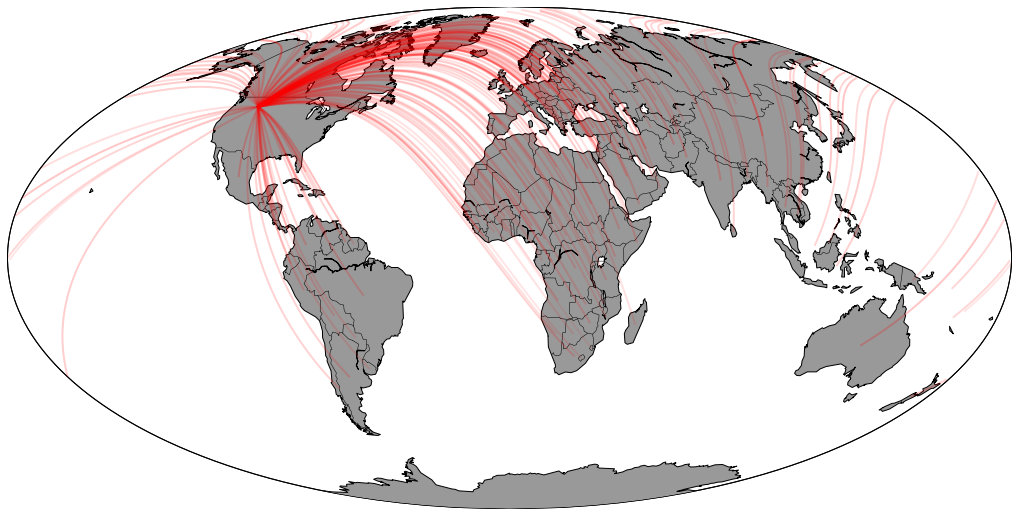

In [20]:
plt.figure(figsize=(18,18))

# Load the world shape map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Country centroids
world['centroid'] = world.centroid
centroids = world.set_index('iso_a3')['centroid']

event_map = Basemap(projection='moll',
                    llcrnrlat=-80,urcrnrlat=80,
                    llcrnrlon=-180,urcrnrlon=180, 
                    lon_0=0, lat_0=0)

event_map.drawcoastlines()
event_map.drawcountries()
event_map.fillcontinents(color='0.6')
event_map.drawmapboundary()

# Assuming grouped_df is defined somewhere before this
for index, row in grouped_df.iterrows():
    country1, country2 = row['sorted_pair']
    if country1 in centroids.index and country2 in centroids.index:
        point1 = centroids.loc[country1]
        point2 = centroids.loc[country2]
        
        # Convert centroids to lat-long for Basemap
        lon1, lat1 = point1.xy
        lon2, lat2 = point2.xy
        
        line_alpha = get_alpha(row['count'])
        
        event_map.drawgreatcircle(lon1[0], lat1[0], lon2[0], lat2[0], 
                                  linewidth=2,
                                  color='r',
                                  alpha=line_alpha)
plt.show()

## Case2: Entity Connection Graph

In [26]:
%%bigquery
SELECT * FROM `gdelt-bq.gdeltv2.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'geg_gcnlapi';

Downloading: 100%|██████████| 13/13 [00:01<00:00, 10.71rows/s]


,table_catalog,table_schema,table_name,column_name,field_path,data_type,description,collation_name,rounding_mode
0,gdelt-bq,gdeltv2,geg_gcnlapi,date,date,TIMESTAMP,None,NULL,None
1,gdelt-bq,gdeltv2,geg_gcnlapi,url,url,STRING,None,NULL,None
2,gdelt-bq,gdeltv2,geg_gcnlapi,lang,lang,STRING,None,NULL,None
3,gdelt-bq,gdeltv2,geg_gcnlapi,polarity,polarity,FLOAT64,None,NULL,None
4,gdelt-bq,gdeltv2,geg_gcnlapi,magnitude,magnitude,FLOAT64,None,NULL,None
5,gdelt-bq,gdeltv2,geg_gcnlapi,score,score,FLOAT64,None,NULL,None
6,gdelt-bq,gdeltv2,geg_gcnlapi,entities,entities,"ARRAY<STRUCT<name STRING, type STRING, mid STR...",None,NULL,None
7,gdelt-bq,gdeltv2,geg_gcnlapi,entities,entities.name,STRING,None,NULL,None
8,gdelt-bq,gdeltv2,geg_gcnlapi,entities,entities.type,STRING,None,NULL,None
9,gdelt-bq,gdeltv2,geg_gcnlapi,entities,entities.mid,STRING,None,NULL,None


In [27]:
%%bigquery entity_graph
SELECT Source, Target, Count RawCount, "Undirected" Type, ( Count/SUM(Count) OVER () ) Weight FROM (
SELECT a.entity Source, b.entity Target, COUNT(*) as Count
FROM (
 (SELECT url, entities.name entity FROM `gdelt-bq.gdeltv2.geg_gcnlapi`, unnest(entities) entities 
  where entities.mid is not null and entities.type = 'PERSON'
  and date >= "2019-02-05 00:00:00" AND date < "2019-02-06 00:00:00")
) a
JOIN (
 (SELECT url, entities.name entity FROM `gdelt-bq.gdeltv2.geg_gcnlapi`, unnest(entities) entities 
  where entities.mid is not null and entities.type = 'PERSON'
  and date >= "2019-02-05 00:00:00" AND date < "2019-02-06 00:00:00")
) b
ON a.url=b.url
WHERE a.entity<b.entity
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 1500
)
order by Count Desc

Downloading: 100%|██████████| 1500/1500 [00:01<00:00, 1263.98rows/s]


In [47]:
entity_graph.head()

,Source,Target,RawCount,Type,Weight
0,Nancy Pelosi,Stacey Abrams,1120,Undirected,0.005300
1,Elizabeth Warren,Kamala Harris,1030,Undirected,0.004875
2,Cory Booker,Kamala Harris,976,Undirected,0.004619
3,Cory Booker,Elizabeth Warren,909,Undirected,0.004302
4,Kamala Harris,Kirsten Gillibrand,888,Undirected,0.004203


In [52]:
entity_graph_filtered = entity_graph[(entity_graph['Source'] == 'Donald Trump') | (entity_graph['Target'] == 'Donald Trump')]

In [53]:
entity_graph_filtered

,Source,Target,RawCount,Type,Weight
7,Donald Trump,Nancy Pelosi,799,Undirected,0.003781
13,Donald Trump,Kamala Harris,727,Undirected,0.003441
17,Donald Trump,Elizabeth Warren,682,Undirected,0.003228
18,Donald Trump,Stacey Abrams,682,Undirected,0.003228
24,Donald Trump,Kirsten Gillibrand,635,Undirected,0.003005
...,...,...,...,...,...
757,Angela Merkel,Donald Trump,97,Undirected,0.000459
814,Donald Trump,God,95,Undirected,0.000450
863,Donald Trump,Juan Guaido,93,Undirected,0.000440
1284,Bush,Donald Trump,86,Undirected,0.000407


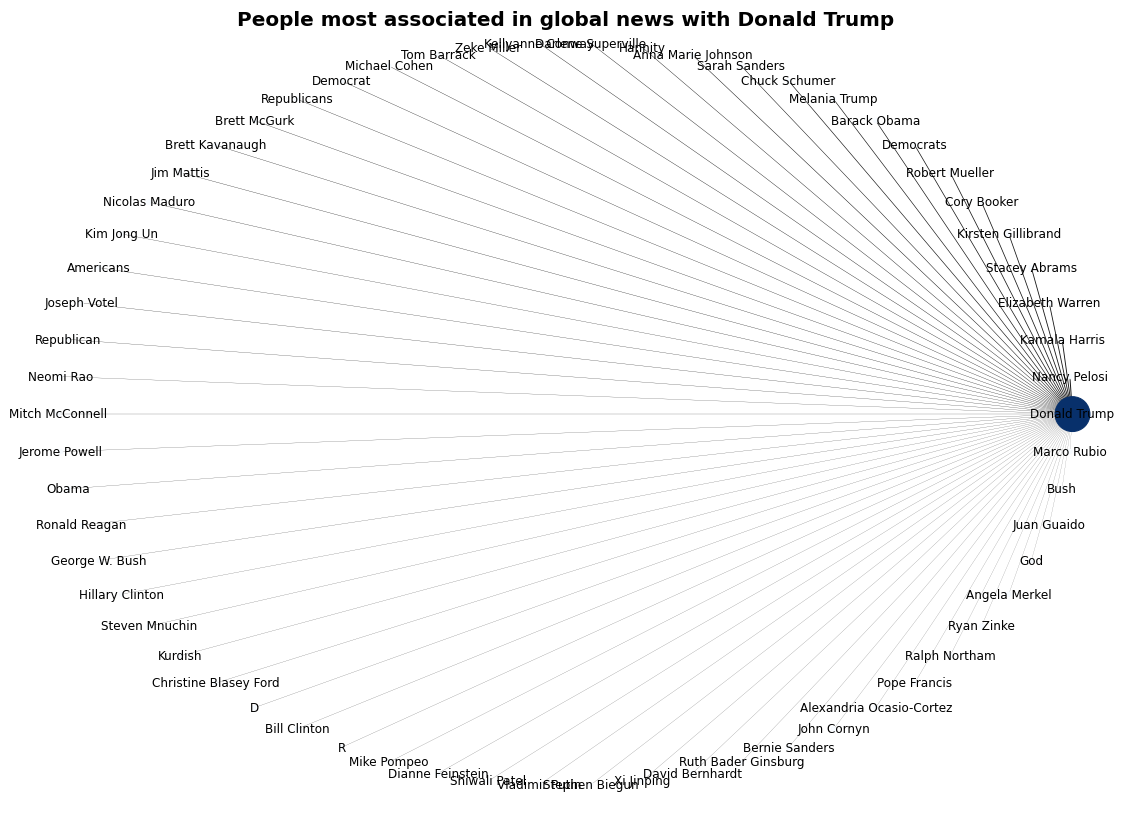

In [71]:
g = nx.Graph()

for index, row in entity_graph_filtered.iterrows():
    g.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Set up with a white background and no grid lines
plt.figure(figsize=(20, 15))
plt.title('People most associated in global news with Donald Trump', y=0.97, fontsize=20, fontweight='bold')
cf = plt.gcf()
ax = cf.gca()
ax.set_axis_off()

# Getting the largest connected component
connected_components = (g.subgraph(c) for c in nx.connected_components(g))
gmax = max(connected_components, key=len)

d = nx.degree(gmax)
b = nx.betweenness_centrality(gmax).items()

# # Use a circular layout
pos = nx.circular_layout(gmax)

edge_weights = nx.get_edge_attributes(gmax, 'weight')
normalized_weights = [weight/max(edge_weights.values()) for weight in edge_weights.values()]

nx.draw_networkx_edges(gmax, pos, nodelist=[v[0] for v in b], alpha=0.9, width=normalized_weights*20)
nx.draw_networkx_nodes(gmax, pos, nodelist=[v[0] for v in b], node_size=[v[1] * 20 for v in d],
                       node_color=[math.log(1 + v[1] * 20) for v in b], cmap=plt.cm.Blues)
nx.draw_networkx_labels(gmax, pos, labels={v[0]: v[0] for v in b})

# Display the graph
plt.show()
